# Starbucks Challenge
### Introduction
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Data
The data is contained in three files:
 - portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
 - profile.json - demographic data for each customer
 - transcript.json - records for transactions, offers received, offers viewed, and offers complete

### portfolio.json
 - id (string) - offer id
 - offer_type (string) - type of offer ie BOGO, discount, informational
 - difficulty (int) - minimum required spend to complete an offer
 - reward (int) - reward given for completing an offer
 - duration (int) - time for offer to be open, in days
 - channels (list of strings)
### profile.json
 - age (int) - age of the customer
 - became_member_on (int) - date when customer created an app account
 - gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
 - id (str) - customer id
 - income (float) - customer's income
### transcript.json
 - event (str) - record description (ie transaction, offer received, offer viewed, etc.)
 - person (str) - customer id
 - time (int) - time in hours since start of test. The data begins at time t=0
 - value - (dict of strings) - either an offer id or transaction amount depending on the record


In [2]:
import pandas as pd
import json
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sb
import datetime

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import calinski_harabasz_score, roc_curve, auc 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# from tqdm.notebook import tqdm
from tqdm import tqdm

from IPython import get_ipython
import sys
import gc
import numpy as np
from scipy.stats.mstats import winsorize
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CasoStarbucks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls Data

portfolio.json	profile.json  transcript.json


`Disclaimer: 
 I did some modifications to the jsons (format related) using a text editor, specialy the transcript one but none affected the data. Could've been done here but I didn't want the notebook to be too bloated.` 

In [4]:
portfolio = pd.read_json('Data/portfolio.json')
profile = pd.read_json('Data/profile.json')
transcript = pd.read_json('Data/transcript.json')

# Preprocessing process

### Profile dataframe

In [5]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


the only unusual feature i see is that the profiles with Nan income are the ones that show very high age values. I'll remove them in a cleaning function later

<AxesSubplot:xlabel='age', ylabel='Count'>

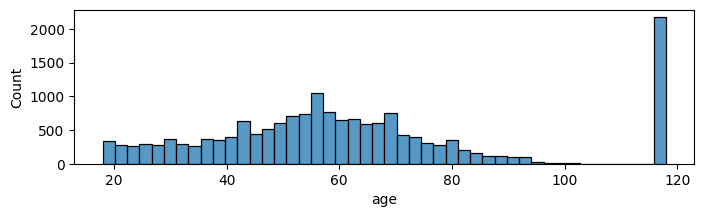

In [6]:
plt.figure(figsize=(8,2))
sb.histplot(data=profile['age'])

In [7]:
null_income_profiles = profile[profile['income'].isnull()]
null_income_profiles.describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


I can see that from users from 118 years and forward present NaN income, however probably there wont be a lot of users with 118

In [8]:
profile[profile['age'] < 90].isnull().sum().sum()

0

When I select users under 90 years old we see that there are no NaN values in the dataframe.

In [9]:
profile['gender'] = profile['gender'].fillna('N')

<AxesSubplot:xlabel='gender', ylabel='Count'>

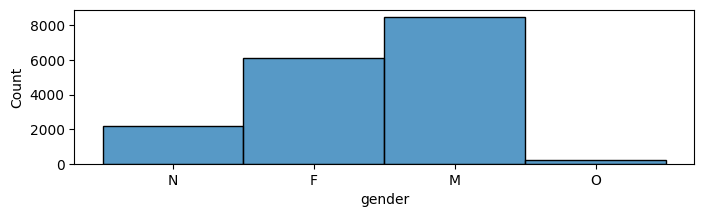

In [10]:
plt.figure(figsize=(8,2))
sb.histplot(profile['gender'])

<AxesSubplot:xlabel='age'>

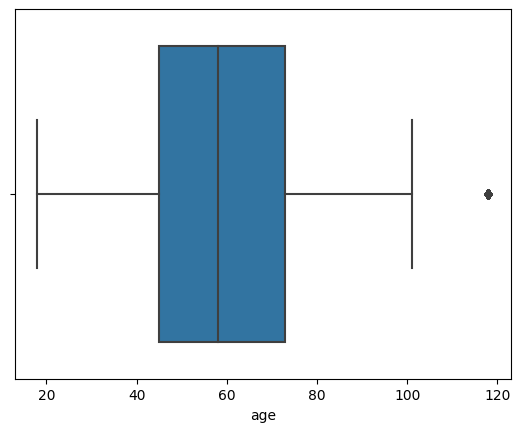

In [11]:
sb.boxplot(data=profile, x='age')

we see that  users with age 118 are users whos gender is none and their income is none so these outlier data has to be deleted

In [12]:
profile[profile['age'] == 118]

,gender,age,id,became_member_on,income
0,N,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,N,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,N,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,N,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,N,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,N,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,N,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,N,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,N,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [13]:
print(profile[profile['age'] < 118]['gender'].value_counts())
print('None income values:', profile[profile['age'] < 118]['income'].isna().sum())

M    8484
F    6129
O     212
Name: gender, dtype: int64
None income values: 0


Exploring income column

In [14]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


<AxesSubplot:xlabel='income', ylabel='Count'>

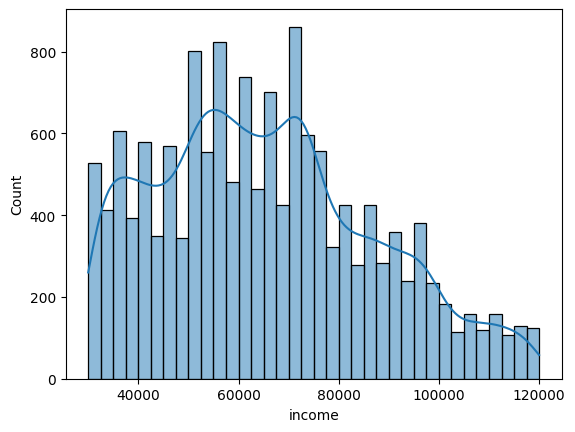

In [15]:
sb.histplot(data=profile, x="income", kde=True)

### Portfolio dataframe

In [16]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In this case we wont worry about Nan Values and we have only 10 rows

The offer types:
 - bogo: buy one get one
 - informational: I assume is the one where you spend \\$10 and you get \\$2
 - discount: a simple discount

In [17]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


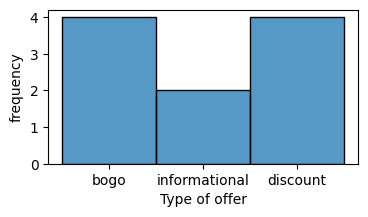

In [18]:
plt.figure(figsize=(4,2))
ax = sb.histplot(data=portfolio['offer_type'])

ax.set(xlabel='Type of offer', ylabel='frequency')
plt.show()

In [19]:
list(portfolio['channels'].values)

[['email', 'mobile', 'social'],
 ['web', 'email', 'mobile', 'social'],
 ['web', 'email', 'mobile'],
 ['web', 'email', 'mobile'],
 ['web', 'email'],
 ['web', 'email', 'mobile', 'social'],
 ['web', 'email', 'mobile', 'social'],
 ['email', 'mobile', 'social'],
 ['web', 'email', 'mobile', 'social'],
 ['web', 'email', 'mobile']]

In [20]:
channels = list(set(sum(list(portfolio['channels'].values), [])))
channels

['mobile', 'social', 'email', 'web']

we see that there are 4 channels where the offers are published

<AxesSubplot:xlabel='difficulty', ylabel='Count'>

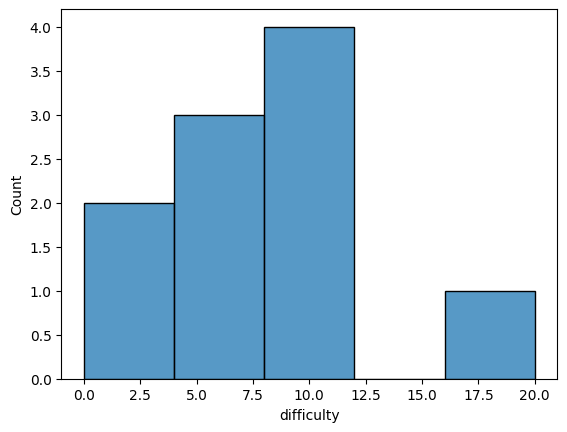

In [21]:
sb.histplot(data=portfolio, x='difficulty')

### Transcript dataframe

In [22]:

transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


<AxesSubplot:xlabel='event', ylabel='Count'>

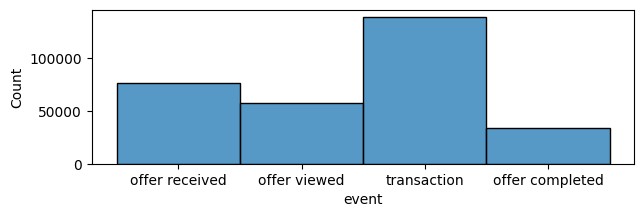

In [23]:
plt.figure(figsize=(7,2))
sb.histplot(data=transcript['event'])

In [24]:
vl = list(transcript['value'].values)

In [25]:
s = []
for v in vl:
    keys = list(v.keys())
    for k in keys:
        if k not in s:
            s += [k]
        else:
            continue
s

['offer id', 'amount', 'offer_id', 'reward']

In a very naive way, we can see what features we can extract from those objects. In the following cells I'll implement a cleaning function to each dataframe and try to understand what each one does and put it in just one dataframe.

## Cleaning data

### Profile dataframe -> users

In [26]:
def clean_profile(df):
    """
        Args: profile dataframe
        Returns:
            the profile dataframe after:
             - removing people older than 90 year old.
             - changing the column names for better understanding
             - change M, O, F to -1, 0 or 1 respectively
             - divide the income number so it can be readed in thousands (since min is 30k and max 112k)
             - cateogirze age and income variables
             - convert dates to unix format
    """
    
    new_df = df.copy()
    
    new_df = new_df.rename(columns={'became_member_on': 'join_date', 'id': 'user_id'})
    new_df = new_df[new_df['age'] < 118]
    
    new_df['join_date'] = pd.to_datetime(new_df['join_date'], format='%Y%m%d')

    return new_df['user_id join_date income age gender'.split()]
    
users = clean_profile(profile)

In [27]:
users

,user_id,join_date,income,age,gender
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,55,F
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,75,F
5,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,68,M
8,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,65,M
12,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,58,M
...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,45,F
16996,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,61,M
16997,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,49,M
16998,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,83,F


- join dates doesnt need to be scaled
- the income age and gender variables are categorical so im gonna one hot encode them 
- the user_id has to be label encoded

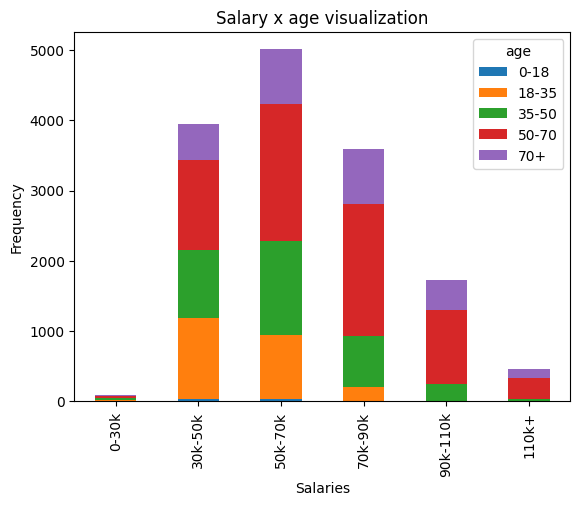

In [28]:
users_plot = users.copy()

age_bins = [0, 18, 35, 50, 70, 105] 
age_labels = ['0-18', '18-35', '35-50','50-70', '70+']
users_plot['age'] = pd.cut(users_plot['age'], bins=age_bins, labels=age_labels)

income_bins = [0, 30000, 50000, 70000, 90000, 110000, 130000]
income_labels = ['0-30k', '30k-50k', '50k-70k','70k-90k', '90k-110k', '110k+']
users_plot['income'] = pd.cut(users_plot['income'], bins=income_bins, labels=income_labels)

contingency_table = pd.crosstab(users_plot['income'], users_plot['age'])

# plot a stacked bar chart
contingency_table.plot(kind='bar', stacked=True)

    

plt.xlabel('Salaries')
plt.ylabel('Frequency')
plt.title('Salary x age visualization')

plt.show()

### Portfolio dataframe -> offers

In [29]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


portoflio doesnt really needs cleaning but im gonna rename some columns and of course store the channels in individual columns but thats gonna be done later

In [30]:
    
def clean_portfolio(df):
    """
        Args: portfolio dataframe
        Returns:
            the portfolio dataframe after:
             - renaming columns
    """
    new_df = df.copy()
      
    # new_df['offer_type'] = new_df['offer_type'].map(map_offer_type)
    new_df = new_df.rename(columns={'offer_type': 'type', 'id': 'offer_id', 'difficulty': 'req'})
    
    return new_df['offer_id req type duration channels reward'.split()]

offers = clean_portfolio(portfolio)

- all the numerical variables need to be scaled
- the type variable has to be one hot encoded
- the offer_id has to be label encoded

In [31]:
offers

,offer_id,req,type,duration,channels,reward
0,ae264e3637204a6fb9bb56bc8210ddfd,10,bogo,7,"[email, mobile, social]",10
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,bogo,5,"[web, email, mobile, social]",10
2,3f207df678b143eea3cee63160fa8bed,0,informational,4,"[web, email, mobile]",0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,bogo,7,"[web, email, mobile]",5
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,discount,10,"[web, email]",5
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,discount,7,"[web, email, mobile, social]",3
6,fafdcd668e3743c1bb461111dcafc2a4,10,discount,10,"[web, email, mobile, social]",2
7,5a8bc65990b245e5a138643cd4eb9837,0,informational,3,"[email, mobile, social]",0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,bogo,5,"[web, email, mobile, social]",5
9,2906b810c7d4411798c6938adc9daaa5,10,discount,7,"[web, email, mobile]",2


In [32]:
offers['type'].value_counts()

bogo             4
discount         4
informational    2
Name: type, dtype: int64

In [33]:

offers['req'].value_counts()

10    4
0     2
5     2
20    1
7     1
Name: req, dtype: int64

### Transcript dataframe -> logs

In [34]:
def clean_transcript(df):
    """
        Args: Transcript dataframe
        Returns:
            the transcript dataframe after:
             - Storing the value info in separate columns
             - Categorizing the event types
             - convert time in hours to days
             - reward now is the reward that the offer gave when the type is offer completed (Points)
             - amount would be the money spent in a transaction (cost)
             - renaming columns
    """
    new_df = df.copy()
    
    new_df['points'] = new_df['value'].apply(lambda x: 0 if 'reward' not in x else x.get('reward'))
    new_df['cost'] = new_df['value'].apply(lambda x: 0 if 'amount' not in x else x.get('amount'))
    new_df['offer_id'] = new_df['value'].apply(lambda x: x.get('offer id') if 'offer id' in x else x.get('offer_id'))
    new_df['offer_id'] = new_df['offer_id'].fillna(0)
    
    new_df = new_df.drop(['value'], axis=1)
    map_event = {'offer received': "offer_received", 
                 'offer viewed': "offer_viewed", 
                 'offer completed' : "offer_completed",
                 'transaction': 'transaction'}
    new_df['event'] = new_df['event'].map(map_event)
    
    new_df['time'] = new_df['time'].apply(lambda x: x/24)
    
    new_df = new_df.rename(columns={"person": "user_id"})
    
    return new_df["offer_id user_id time cost points event".split()]

logs = clean_transcript(transcript)

In [35]:
logs.isna().sum()

offer_id    0
user_id     0
time        0
cost        0
points      0
event       0
dtype: int64

<AxesSubplot:xlabel='event', ylabel='time'>

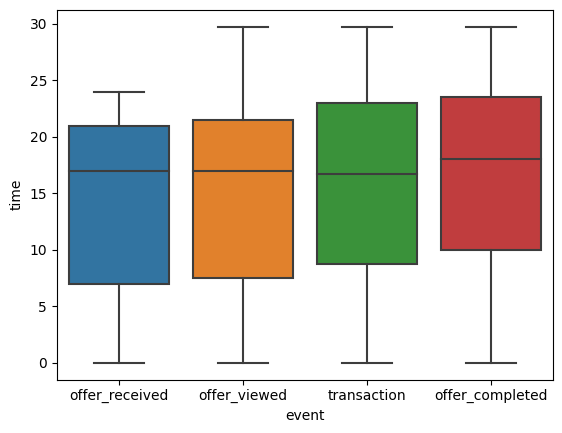

In [36]:
sb.boxplot(data=logs, x='event', y='time')

I can see that this plot just makes sense because the receivement and the view of an offer is usualy before any transaction or offer completion. And also i can see that there are not really any outliers related to the time where the transaction appears

In [37]:
logs.head()

,offer_id,user_id,time,cost,points,event
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0.0,0,offer_received
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,0.0,0.0,0,offer_received
2,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0.0,0,offer_received
3,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,0.0,0.0,0,offer_received
4,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,0.0,0.0,0,offer_received


In [38]:
offers.head()

,offer_id,req,type,duration,channels,reward
0,ae264e3637204a6fb9bb56bc8210ddfd,10,bogo,7,"[email, mobile, social]",10
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,bogo,5,"[web, email, mobile, social]",10
2,3f207df678b143eea3cee63160fa8bed,0,informational,4,"[web, email, mobile]",0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,bogo,7,"[web, email, mobile]",5
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,discount,10,"[web, email]",5


In [39]:

users.head()

,user_id,join_date,income,age,gender
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,55,F
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,75,F
5,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,68,M
8,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,65,M
12,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,58,M


### Merging the dataframes

Since this is an unsupervised learning problem, the idea is to identify clusters the data in a meaningful way using algorithms so we can understand those clusters and solve the question of which demographic groups respond better to which kinds of offer.

My first idea was to merge the user information into the transcript (logs) dataframe the way I can and on top of that merge the offer info. I tried it using kmeans and hierarchical clustering and the clusters give a quality of ~0.15 using silhouette score using cluster sizes from 2 to 8. 

So the idea i have now is to cluster the user dataframe. So im gonna try to merge the data in a smarter way. Im gonna merge the transactions and the offers in order to have data about each transactions weather or not it uses an offer and after that im gonna do feature engineering to add every feature neccesary to the user dataframe in order to cluster that dataframe more accuratelly expecting a higher silhouette score. (the silhouette score was higher but only ~0.20)

Im gonna go harder on feature engineering this time and as long and if this time the silhouette score or the clusters themselves are not very good then im gonna try to turn this into a classification problem which should be easier.

#### ID's encoding and cleaning
I found some users that appear in the transcript but not in the profile dataset. Thats why im gonna perform an inner join in order to have only the transaction that have a matching user id in the user dataframe.

In [40]:
userEncoder = LabelEncoder()
offerEncoder = LabelEncoder()

offerEncoder.fit_transform(offers['offer_id'])
userEncoder.fit_transform(users['user_id'])

array([  346,  6962, 13107, ...,    93,  9208, 13230])

In [41]:
offers['offer_id'] = offerEncoder.fit_transform(offers['offer_id'])
users['user_id'] = userEncoder.fit_transform(users['user_id'])

logs['offer_id'] = offerEncoder.fit_transform(logs['offer_id'].astype(str))
logs['user_id'] = userEncoder.fit_transform(logs['user_id'].astype(str))

### Merging

In [42]:

simple_trans = logs[logs['event'] == 'transaction']
logs = logs[logs['event'] != 'transaction']

In [43]:
users.head()

,user_id,join_date,income,age,gender
1,346,2017-07-15,112000.0,55,F
3,6962,2017-05-09,100000.0,75,F
5,13107,2018-04-26,70000.0,68,M
8,3246,2018-02-09,53000.0,65,M
12,2669,2017-11-11,51000.0,58,M


In [44]:
logs_user = logs.merge(users, on='user_id')

In [45]:
logs_user_offer = logs_user.merge(offers, on='offer_id')

In [46]:
logs_user_offer.isna().sum()

offer_id     0
user_id      0
time         0
cost         0
points       0
event        0
join_date    0
income       0
age          0
gender       0
req          0
type         0
duration     0
channels     0
reward       0
dtype: int64

### Feature Engineering

im gonna try to add the total amount spent by user and the frequency of transactions for each user. This will be done by analizing the transaction events in the simple_trans dataframe

also im gonan add an income-per-age column and a column which is number of orders completed by the user in question

im gonna add the ratio of viewed-offers and completed-offers 

im also gonna separete the join date in month and year and drop the time column since i cant find a use to it.

drop the channels as well

In [47]:
grouped = simple_trans.groupby('user_id').agg({'cost': 'sum', 'user_id': 'count'})
grouped = grouped.rename(columns={'cost': 'total_spent', 'user_id': 'frequency'})

In [48]:
grouped = grouped.reset_index()

In [49]:
df = logs_user_offer.merge(grouped, on='user_id')

In [50]:
most_frequent_offer = df.groupby('user_id')['type'].agg(lambda x: x.value_counts().index[0]).reset_index(name='most_frequent_type')


In [51]:
df = df.merge(most_frequent_offer, on='user_id')

In [52]:
df.isna().sum()

offer_id              0
user_id               0
time                  0
cost                  0
points                0
event                 0
join_date             0
income                0
age                   0
gender                0
req                   0
type                  0
duration              0
channels              0
reward                0
total_spent           0
frequency             0
most_frequent_type    0
dtype: int64

In [53]:
df = df.drop('offer_id cost reward'.split(), axis=1)

In [54]:
df.head()

,user_id,time,points,event,join_date,income,age,gender,req,type,duration,channels,total_spent,frequency,most_frequent_type
0,7996,0.00,0,offer_received,2015-10-11,55000.0,20,M,10,bogo,7,"[email, mobile, social]",159.27,7,bogo
1,7996,0.25,0,offer_viewed,2015-10-11,55000.0,20,M,10,bogo,7,"[email, mobile, social]",159.27,7,bogo
2,7996,5.50,5,offer_completed,2015-10-11,55000.0,20,M,10,bogo,7,"[email, mobile, social]",159.27,7,bogo
3,7996,7.00,0,offer_received,2015-10-11,55000.0,20,M,5,bogo,7,"[web, email, mobile]",159.27,7,bogo
4,7996,9.00,0,offer_viewed,2015-10-11,55000.0,20,M,5,bogo,7,"[web, email, mobile]",159.27,7,bogo


<Axes: xlabel='gender'>

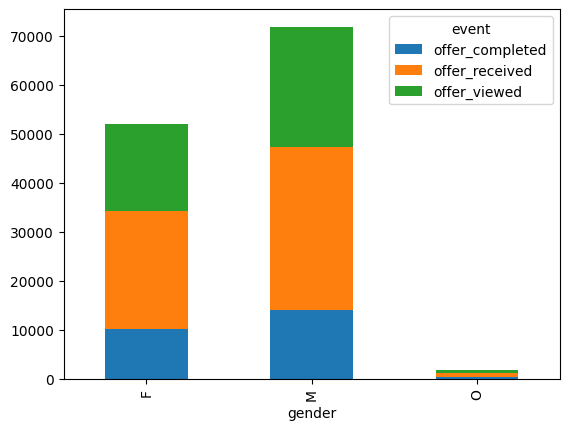

In [55]:
freqs_by_gender = df.groupby(['gender', 'event'])['event'].count().unstack()
freqs_by_gender.plot(kind='bar', stacked=True)


I will consider gender as categorical

[]

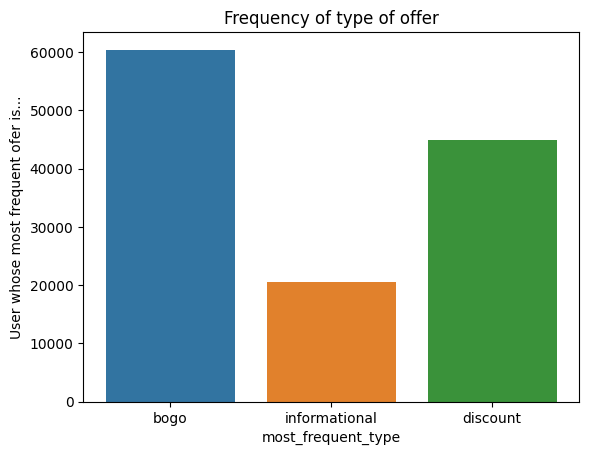

In [56]:

ax = sb.countplot(x='most_frequent_type', data=df)

plt.title("Frequency of type of offer")
plt.ylabel("User whose most frequent ofer is...")
plt.plot()

In [57]:
# add income per age
df['income/age'] = df['income'] / df['age']

In [58]:
df['income/age']

0         2750.000000
1         2750.000000
2         2750.000000
3         2750.000000
4         2750.000000
             ...     
125798    2034.482759
125799    2034.482759
125800     868.852459
125801     868.852459
125802     868.852459
Name: income/age, Length: 125803, dtype: float64

In [59]:
df['join_date'] = pd.to_datetime(df['join_date'])
df['join_year'] = df['join_date'].dt.year
df['join_month'] = df['join_date'].dt.month

In [60]:
df.head()

,user_id,time,points,event,join_date,income,age,gender,req,type,duration,channels,total_spent,frequency,most_frequent_type,income/age,join_year,join_month
0,7996,0.00,0,offer_received,2015-10-11,55000.0,20,M,10,bogo,7,"[email, mobile, social]",159.27,7,bogo,2750.0,2015,10
1,7996,0.25,0,offer_viewed,2015-10-11,55000.0,20,M,10,bogo,7,"[email, mobile, social]",159.27,7,bogo,2750.0,2015,10
2,7996,5.50,5,offer_completed,2015-10-11,55000.0,20,M,10,bogo,7,"[email, mobile, social]",159.27,7,bogo,2750.0,2015,10
3,7996,7.00,0,offer_received,2015-10-11,55000.0,20,M,5,bogo,7,"[web, email, mobile]",159.27,7,bogo,2750.0,2015,10
4,7996,9.00,0,offer_viewed,2015-10-11,55000.0,20,M,5,bogo,7,"[web, email, mobile]",159.27,7,bogo,2750.0,2015,10


In [61]:
df.isna().sum()

user_id               0
time                  0
points                0
event                 0
join_date             0
income                0
age                   0
gender                0
req                   0
type                  0
duration              0
channels              0
total_spent           0
frequency             0
most_frequent_type    0
income/age            0
join_year             0
join_month            0
dtype: int64

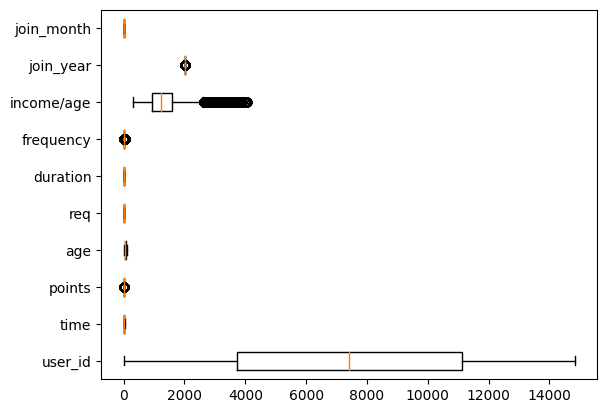

In [62]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.pop(numerical_cols.index('income'))
numerical_cols.pop(numerical_cols.index('total_spent'))
plt.boxplot(df[numerical_cols].values, labels=numerical_cols, vert=False)
plt.show()

total spent and points also present a lot of outliers

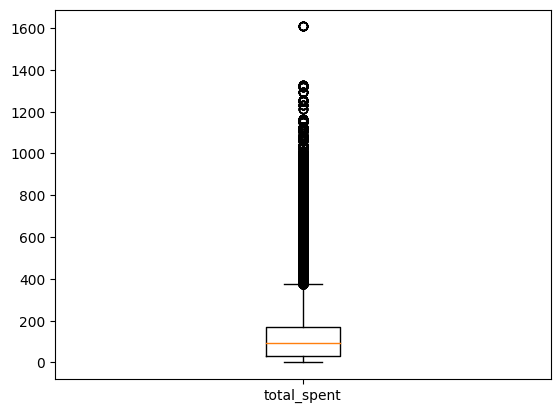

In [63]:
rest_cols = 'total_spent'.split()
plt.boxplot(df[rest_cols].values, labels=rest_cols)
plt.show()

this function will get the interquartile range between 0.25 and 0.75 and then clip the data to that range, every value that exceeds or is below the 0.25 or 0.75 range will be replaced to the higher or lower value in that range. Then im performin winsorization which is done to replace the extreme values with the closest non-outlier value in a defined range which in this case is 5% un the upper bound and 5% in the lower bound as a default setting

In [64]:
def treat_outliers(col):
    # using interquartile range
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    # clipping the data to make it ready for winsorization
    lower_bound, upper_bound = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    clipped = np.clip(col, lower_bound, upper_bound)
    

    return  winsorize(clipped, limits=(0.05, 0.05))

In [65]:
df['total_spent'] = treat_outliers(df['total_spent'])
df['points'] = treat_outliers(df['points'])
df['frequency'] = treat_outliers(df['frequency'])
df['income/age'] = treat_outliers(df['income/age'])

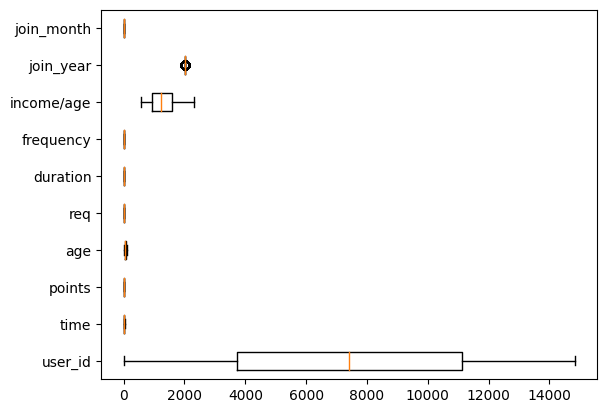

In [66]:
plt.boxplot(df[numerical_cols].values, labels=numerical_cols, vert=False)
plt.show()

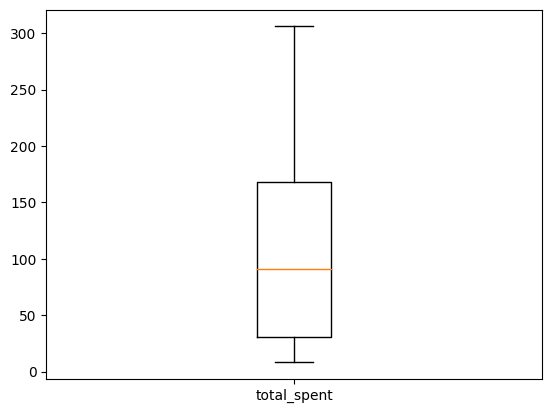

In [67]:
plt.boxplot(df[rest_cols].values, labels=rest_cols)
plt.show()

as wee see the outliers in the numerical columns are fixed

### prepare dataframe to for clustering
Im gonna try and group the features in N groups so i can cluster using more less different features and ways to treat the features in order to test which group works better.

In [68]:
df.head()

,user_id,time,points,event,join_date,income,age,gender,req,type,duration,channels,total_spent,frequency,most_frequent_type,income/age,join_year,join_month
0,7996,0.00,0,offer_received,2015-10-11,55000.0,20,M,10,bogo,7,"[email, mobile, social]",159.27,7.0,bogo,2304.347826,2015,10
1,7996,0.25,0,offer_viewed,2015-10-11,55000.0,20,M,10,bogo,7,"[email, mobile, social]",159.27,7.0,bogo,2304.347826,2015,10
2,7996,5.50,0,offer_completed,2015-10-11,55000.0,20,M,10,bogo,7,"[email, mobile, social]",159.27,7.0,bogo,2304.347826,2015,10
3,7996,7.00,0,offer_received,2015-10-11,55000.0,20,M,5,bogo,7,"[web, email, mobile]",159.27,7.0,bogo,2304.347826,2015,10
4,7996,9.00,0,offer_viewed,2015-10-11,55000.0,20,M,5,bogo,7,"[web, email, mobile]",159.27,7.0,bogo,2304.347826,2015,10


In [69]:
df.columns

Index(['user_id', 'time', 'points', 'event', 'join_date', 'income', 'age',
       'gender', 'req', 'type', 'duration', 'channels', 'total_spent',
       'frequency', 'most_frequent_type', 'income/age', 'join_year',
       'join_month'],
      dtype='object')

Text(0.5, 1.0, 'count of offer types')

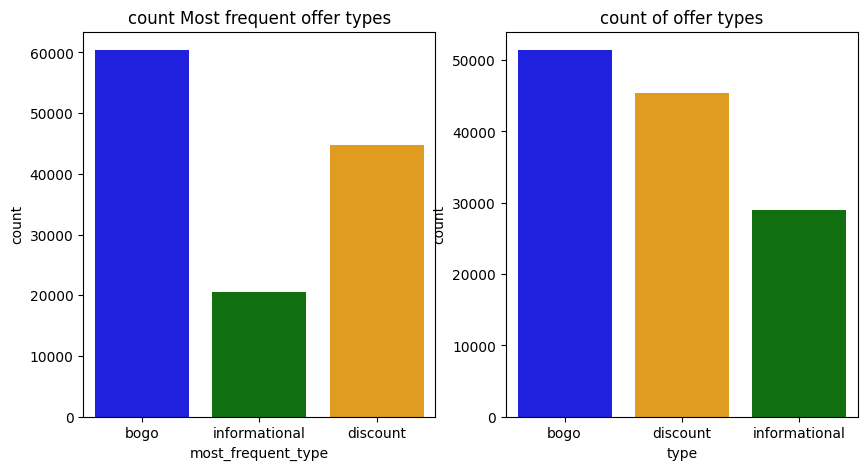

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

palette = {"bogo": "blue", "informational": "green", "discount": "orange"}

sb.countplot(data=df, x='most_frequent_type', ax=axes[0], palette=palette)
sb.countplot(data=df, x='type', ax=axes[1], palette=palette)

axes[0].set_title("count Most frequent offer types")
axes[1].set_title("count of offer types")

In [71]:
df_Y = pd.Series([])
def cleaning_features_A(data):
    global df_Y
    new_df = data.copy()
   

    new_df = new_df[new_df['event'] != 'offer_received']

    df_Y = new_df['type']
    new_df = pd.get_dummies(new_df, columns = 'gender type'.split())
    
    new_df['age'] = new_df['age'].apply(lambda x: (x//10) * 10)

    new_df.rename(columns = {'most_frequent_type_bogo': 'freq_bogo',
                             'most_frequent_type_discount': 'freq_discount',
                             'most_frequent_type_informational': 'freq_info'}, inplace=True )

    new_df = new_df.drop('user_id points join_date channels time event most_frequent_type req'.split(), axis=1)
    
    return new_df

df_A = cleaning_features_A(df)

df_A.head()

<ipython-input-71-559dfdb7e26d>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_Y = pd.Series([])


,income,age,duration,total_spent,frequency,income/age,join_year,join_month,gender_F,gender_M,gender_O,type_bogo,type_discount,type_informational
1,55000.0,20,7,159.27,7.0,2304.347826,2015,10,0,1,0,1,0,0
2,55000.0,20,7,159.27,7.0,2304.347826,2015,10,0,1,0,1,0,0
4,55000.0,20,7,159.27,7.0,2304.347826,2015,10,0,1,0,1,0,0
6,55000.0,20,5,159.27,7.0,2304.347826,2015,10,0,1,0,1,0,0
7,55000.0,20,5,159.27,7.0,2304.347826,2015,10,0,1,0,1,0,0


In [72]:
len(df_Y)

67354

In [73]:
df_A.shape

(67354, 14)

### Clustering
- The metric im gonna use the silhouette score and the Calinski-Harabasz Index to determine which algorithm works best and with how many clusters
- Im gonna use kmeans, hierarchical clustering and DBSCAN as clustering algorithms

Just so i dont overflow...

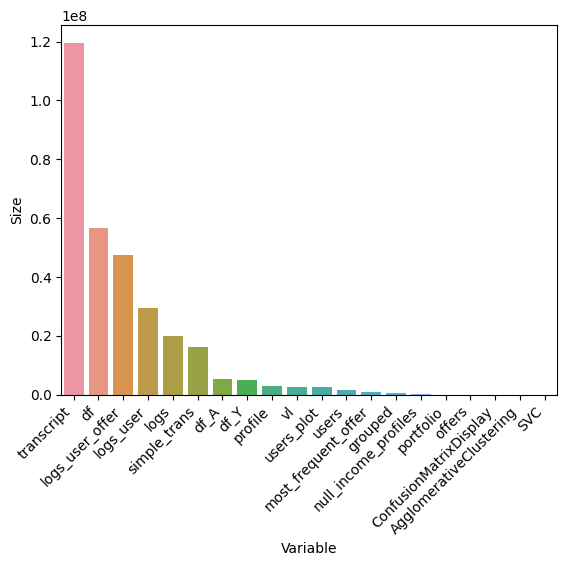

In [74]:
variables = %who_ls
sizes = [sys.getsizeof(globals()[var]) for var in variables]
loc = pd.DataFrame({'Variable': variables, 'Size': sizes}).sort_values('Size', ascending=False)

sb.barplot(data=loc.head(20),x='Variable', y='Size')
plt.xticks(rotation=45, ha='right')
plt.show()

In [76]:
# raise Exception("sure?")
del transcript, logs_user_offer, logs_user, logs, simple_trans

In [83]:
types_index = (df_A.columns.get_loc('type_bogo'), df_A.columns.get_loc('type_informational'))
income_index = df_A.columns.get_loc('income')
age_index = df_A.columns.get_loc('age')
scaler = MinMaxScaler()
df_A = scaler.fit_transform(df_A)

df_A[:, types_index[0]:types_index[1]]
df_A[:, types_index[0]:types_index[1]] = df_A[:, types_index[0]:types_index[1]] * 2
df_A[:, income_index] = df_A[:, income_index] *1.05

### Kmeans
I was trying hierarchical clustering but it uses too much RAM.

In [ ]:
clusters = [3,4,5,6,7]
benchmark = { 'kmeans': { 'silhouette': [], 'calinski': [] },
                'agg' : { 'silhouette': [], 'calinski': [] } }


for c in tqdm(clusters):
    kmeans = KMeans(n_clusters=c, random_state=42)
    # agg = AgglomerativeClustering(n_clusters=c)

    # agg.fit(df_A)
    kmeans.fit(df_A)

    kmeans_labels = kmeans.labels_
    # agg_labels = agg.labels_
    
    benchmark['kmeans']['silhouette'] += [silhouette_score(df_A, kmeans_labels)]
    benchmark['kmeans']['calinski'] += [calinski_harabasz_score(df_A, kmeans_labels)]
    
    # benchmark['agg']['silhouette'] += [silhouette_score(df_A, agg_labels)]
    # benchmark['agg']['calinski'] += [calinski_harabasz_score(df_A, agg_labels)]

print(json.dumps(benchmark, indent=1))

Test with DBScan
 

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:

dbscan = DBSCAN(eps=0.5, min_samples=5)


dbscan.fit(df_A)

labels = dbscan.labels_
silhouette_avg = silhouette_score(df_A, labels)


In [ ]:
print("Silhouette score for dbscan:", silhouette_avg)

labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters:', n_clusters)


I tried to take an unsupervised learning approach but the first silhouette sizes i got were around 0.05 and 0.20. After trying different feature engineering tasks and dropping features I got a 0.42 using kmeans (6 clusters) and 0.411 using dbscan.

After multiplying by 2 the types of offer, the kmeans model got to 0.49 in silhouette score using 3 clusters but dbscan staid con 0.41

I understand that the silhouette score is not the only metric I have to analyze but it gives a solid idea of the similarity of the items in each cluster. 


So im gonna try to give some conclusion on top of those clusters and after that try the same with a supervised learning approach which I don't think it would be the best approach in a real case scenario

In [ ]:
n_clusters = 6

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

kmeans.fit(df_A)



In [77]:
cols = "income age duration total_spent frequency income/age join_year join_month gender_F gender_M gender_O type_bogo type_discount type_informational".split()

In [ ]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

df_centroids = pd.DataFrame(centroids, columns=cols)

# Print the dataframe
df_centroids.round(3).sort_values('income')

### Cluster analyzis

I sorted the clusters by income because i see a difference between the first three and the last three. Their income and age. We can also see that the last three present more female gender than the first three.

In [ ]:

# Get the size and density of each cluster
labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print("Cluster sizes:", cluster_sizes)

cluster_densities = {}
for i in range(kmeans.n_clusters):
    distances = kmeans.transform(df_A)[:, i]
    density = sum(distances) / len(distances)
    cluster_densities[i] = density
print("Cluster densities:", cluster_densities)

In [ ]:
df =  pd.DataFrame(data=scaler.inverse_transform(df_A), columns=cols)
df['cluster'] = labels

In [ ]:
plt.figure(figsize=(3,1))
df_means_long = pd.melt(df[['income', 'cluster']], id_vars=['cluster'], var_name='feature', value_name='mean')
# Create bar charts for each cluster and feature
g = sb.catplot(x='feature', y='mean', hue='cluster', data=df_means_long, kind='bar', height=4, aspect=3)
g.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
plt.figure(figsize=(3,1))
df_means_long = pd.melt(df['cluster type_bogo type_informational type_discount'.split()], id_vars=['cluster'], var_name='feature', value_name='mean')
# Create bar charts for each cluster and feature
g = sb.catplot(x='feature', y='mean', hue='cluster', data=df_means_long, kind='bar', height=4, aspect=3)
g.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Kmeans suggests that the dataset is not separated since the centroids it shows are very similar. Im gonna try to classify the type of offer with a couple classifying algorithms
### Classification task

I'm gonna ignore the 'informational' just to be able to plot a ROC curve between the predictions of bogo type and discount type

In [78]:
encoder = LabelEncoder()
df_Y = encoder.fit_transform(df_Y)

In [79]:
np.unique(df_Y)

array([0, 1, 2])

In [84]:
df_A = scaler.inverse_transform(df_A)
df_A = pd.DataFrame(df_A, columns=cols)
to_drop = 'type_bogo type_discount type_informational'.split()
df_A = df_A.drop(to_drop, axis=1)

In [85]:
del_indices = np.where(df_Y == 2)[0]
print(del_indices)
df_B = df_A.drop(del_indices.tolist())

[    8     9    18 ... 67251 67252 67253]


In [86]:
df_Binary_Y = df_Y[np.where(df_Y != 2)]

In [87]:
df_Binary_Y.shape, df_B.shape

((51284,), (51284, 11))

In [88]:
df_A.shape, df_Y.shape

((67354, 11), (67354,))

In [89]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_A, df_Y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_B, df_Binary_Y, test_size=0.2, random_state=42)

### Random forest classifier
In this case im using rf for classification not regression. It uses a decision tree technique so in this case, since i got a lot of features in this dataframe it can handle them to prevent overfitting. 

In [90]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_3, y_train_3)

y_pred_3 = rfc.predict(X_test_3)

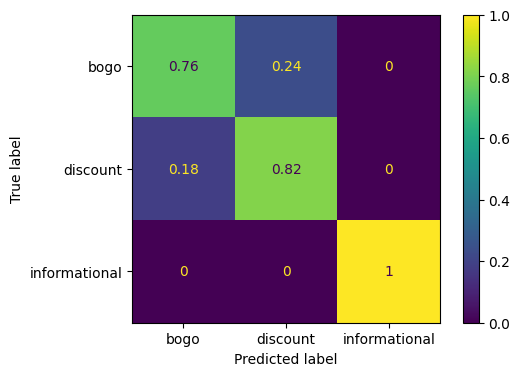

In [91]:
fig, ax = plt.subplots(figsize=(6,4))
cm = confusion_matrix(y_test_3, y_pred_3, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bogo', 'discount', 'informational'])
disp.plot(ax=ax)
plt.show()

### Now using only bogo and discount. because informational is not giving relevant output

In [93]:
benchmark = {
    'rfc': {
        'fpr': 0,
        'tpr': 0,
        'roc_auc': 0
    },
    'svm': {
        'fpr': 0,
        'tpr': 0,
        'roc_auc': 0
    },
    'lr': {
        'fpr': 0,
        'tpr': 0,
        'roc_auc': 0
    }
    
}

### Random forest again

In [113]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

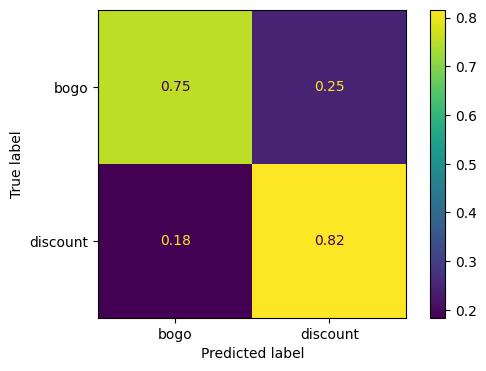

In [114]:
fig, ax = plt.subplots(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bogo', 'discount'])
disp.plot(ax=ax)
plt.show()

In [115]:


fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

benchmark['rfc']['roc_auc'] = roc_auc
benchmark['rfc']['fpr'] = fpr
benchmark['rfc']['tpr'] = tpr

### SVM
SVM shouldn't be a model with good performance in this case since it's gonna try to separate the data finding the best function that differenciate the data in the hyperplane. Since kmeans didn't worked well, svm shouldn't but maybe it gives a good answer now that we're trying to classify instead of clusterize.

I stopped the linear kernel after 15m because i didnt think the output was gonna be good.

The poly kernel didn't do good either.

In [116]:
svm = SVC(kernel='poly')

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)


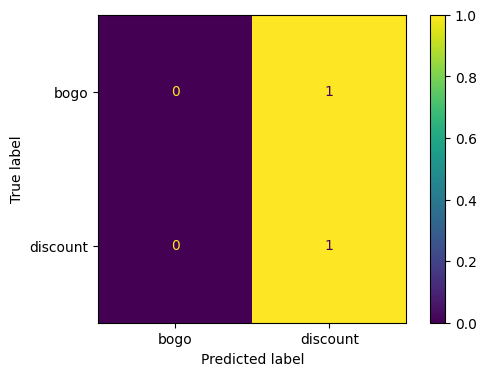

In [117]:
fig, ax = plt.subplots(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bogo', 'discount'])
disp.plot(ax=ax)
plt.show()

In [118]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

benchmark['svm']['roc_auc'] = roc_auc
benchmark['svm']['fpr'] = fpr
benchmark['svm']['tpr'] = tpr

### Logistic regresion

logistic regression shouldn't be an approach to classify offer types but is often used for binary classification as well.

In [119]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

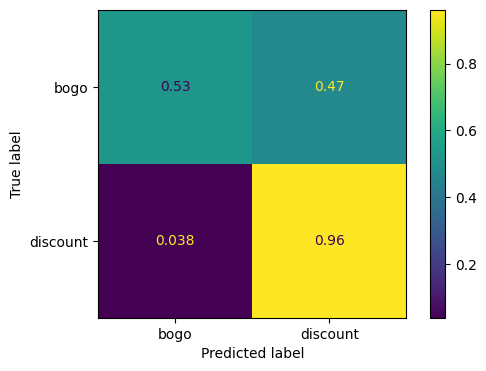

In [120]:
fig, ax = plt.subplots(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bogo', 'discount'])
disp.plot(ax=ax)
plt.show()

In [121]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

benchmark['lr']['roc_auc'] = roc_auc
benchmark['lr']['fpr'] = fpr
benchmark['lr']['tpr'] = tpr

### KNN

Knn is a very lazy algorithm in this case im only gonna try it with 5 neighbors because im thinking that the decision tree algorithms will perform better.

In [129]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

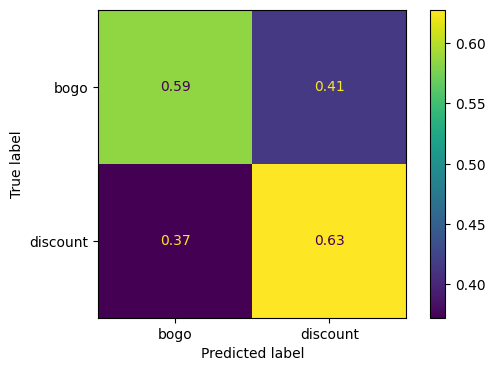

In [130]:
fig, ax = plt.subplots(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bogo', 'discount'])
disp.plot(ax=ax)
plt.show()

In [132]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)
benchmark['knn'] = {}
benchmark['knn']['roc_auc'] = roc_auc
benchmark['knn']['fpr'] = fpr
benchmark['knn']['tpr'] = tpr

## Decision trees  Algorithms

Since random forest got the best performance so far im gonna try these two other decision tree algorithms, cart and id3. They're both suitable for regression and classification tasks.

### CART Algorithm
 Classification and Regression Trees. Its a binary tree algorithm, is prone to overfitting but can give good results.

In [135]:
cart = DecisionTreeClassifier(criterion='gini')
cart.fit(X_train, y_train)
y_pred = cart.predict(X_test)


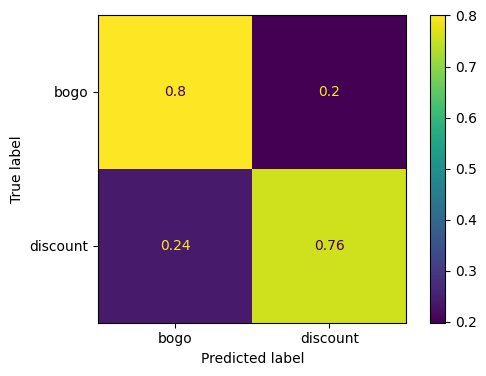

In [136]:
fig, ax = plt.subplots(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bogo', 'discount'])
disp.plot(ax=ax)
plt.show()

In [137]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)
benchmark['cart'] = {}
benchmark['cart']['roc_auc'] = roc_auc
benchmark['cart']['fpr'] = fpr
benchmark['cart']['tpr'] = tpr

###  ID3 algorithm
Iterative Dichotomiser 3, is faster than cart even though is a decision tree algorithm rather than binary tree.

In [138]:
id3 = DecisionTreeClassifier(criterion='entropy')
id3.fit(X_train, y_train)
y_pred = id3.predict(X_test)

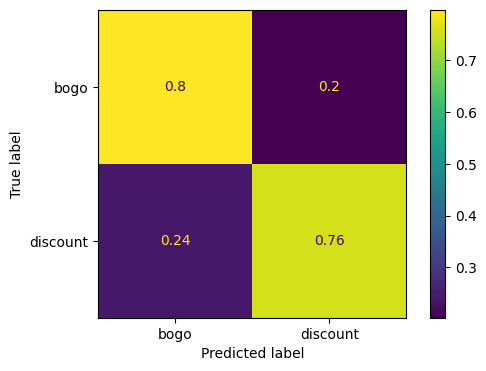

In [139]:
fig, ax = plt.subplots(figsize=(6,4))
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bogo', 'discount'])
disp.plot(ax=ax)
plt.show()

In [140]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)
benchmark['id3'] = {}
benchmark['id3']['roc_auc'] = roc_auc
benchmark['id3']['fpr'] = fpr
benchmark['id3']['tpr'] = tpr

### Comparing roc curves

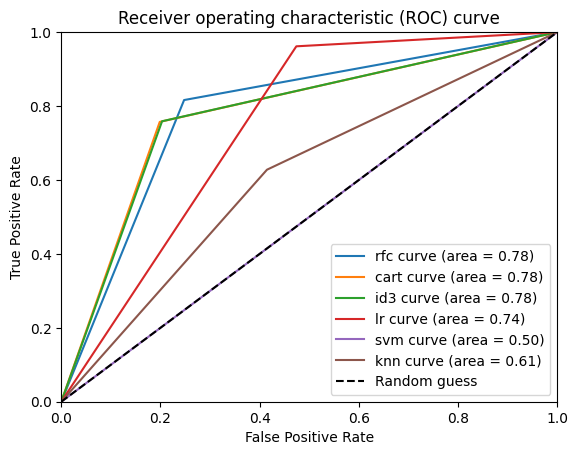

In [142]:

def plot_line(algo):
    plt.plot( benchmark[algo]['fpr'], benchmark[algo]['tpr'],
             label=algo +' curve (area = %0.2f)' %  benchmark[algo]['roc_auc'])

plot_line('rfc')
plot_line('cart')
plot_line('id3')
plot_line('lr')
plot_line('svm')
plot_line('knn')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

## Conclusion
The goal was to define which demographic sector responds best to which type of offer. First thing I tried was clusterization so I could compare different groups of users. Then I realized the quality of the clusters wasn't very good so I tried to group the transcript data so I could compare groups of transactions. The best silhouette score I got was 0.49 after trying different approaches. So I concluded that the dataset is not very clusterable because the distances between the data cannot be measured easily. I could've created my own distance function in order to give more or less importance to certain features. I tried dimensionality reduction algorithms like PCA but the output was the same. 

So I decided to just classify the offer type. The best model was the random forest and other tree algorithms like id3 and cart. I used the dataset after merging the three dataset. I also tried many different ways to merge and clean the data.